In [1]:
# Prepare workspace
import pandas as pd
import numpy as np
import json
import h5py
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

# fix seed for repeatability
np.random.seed(1)

In [2]:
# Arguments
class Args():
    pass
args = Args()

args.input_actions = 'data/mars_tianchi_user_actions.csv'
args.input_songs = 'data/mars_tianchi_songs.csv'
args.output_h5 = 'data/mars_tianchi_group_actions.h5'
args.output_json = 'data/mars_tianchi_group_actions.json'
args.output_csv = 'data/mars_tianchi_group_actions.csv'
args.val_frac = 0.1
args.val_along_dimension = 'group' # possible values include: group, time
args.test_frac = 0.1
args.num_group = 1

In [3]:
# Load actions
actions = pd.read_csv(args.input_actions,
                      names=['user_id', 'song_id', 'gmt_create', 'action_type', 'Ds'],)


In [4]:
# Load song information
song_info = pd.read_csv(args.input_songs,
                        names=['song_id', 'artist_id', 'publish_time', 'song_init_plays', 'lang', 'gender'],)

In [5]:
# Assign user group
users = actions.user_id.unique() # pandas's unique method seems to be much faster than numpy.unique() method
user_groups = np.random.randint(0, args.num_group, users.shape) # another way to assign user group is to first randomly permutate all users, 
                                                                # then assign groups sequentially 


In [6]:
# Merge information into one DataFrame
d = {'user_id': users, 'user_group': user_groups}
user_info = pd.DataFrame(d)
actions_with_group = pd.merge(actions, user_info) # another method will be to use DataFrame's assign() method, 
                                                                                  # however since merge takes just about 3 seconds this doesn't 
                                                                                 #  seem to be neccesary
actions_with_group_artist = pd.merge(actions_with_group, song_info)

In [7]:
# Accumulate group play records
# We use the split-apply-combine methodology to achieve this

# split by user_group Ds artist_id. This is extreamly fast.
actions_grouped = actions_with_group_artist.groupby(['user_group', 'Ds', 'artist_id'])

# aggregate group size
actions_grouped_size = actions_grouped.size()

In [8]:
#  Build conversion map
dates = np.sort(actions.Ds.unique())
T = dates.shape[0]
dates_to_idx = {dates[i] : i for i in xrange(dates.shape[0])}

artists = song_info.artist_id.unique()
D = artists.shape[0]
artist_to_idx = {artists[i] : i for i in xrange(artists.shape[0])}          

In [9]:
# Store play records in ndarray
G = args.num_group
play_records = np.zeros((G, T, D), dtype='int32')
for index, value in actions_grouped_size.iteritems():
    i = index[0]
    j = dates_to_idx[index[1]]
    k = artist_to_idx[index[2]]
    
    play_records[i, j, k] = value

In [10]:
# split by Ds artist_id action_type. This is extreamly fast.
actions_grouped_by_artist = actions_with_group_artist.groupby(['artist_id', 'Ds', 'action_type'])

# aggregate group size
actions_grouped_by_artist_size = actions_grouped_by_artist.size()

In [11]:
# Initialize DataFrame to store daily information include play, download and collection operation
artist_daily_play = pd.DataFrame(index=dates, columns=artists)
artist_daily_download = pd.DataFrame(index=dates, columns=artists)
artist_daily_collects = pd.DataFrame(index=dates, columns=artists)

# Iterate through the grouped size to get daily operations number
for index, data in actions_grouped_by_artist_size.iteritems():
    artist = index[0]
    date = index[1]
    type_ = index[2]
    if type_ == 1:
        artist_daily_play.loc[date, artist] = data
    elif type_ == 2:
        artist_daily_download.loc[date, artist] = data
    elif type_ == 3:
        artist_daily_collects.loc[date, artist] = data

# filling nan with zero
artist_daily_play.fillna(0, inplace=True)
artist_daily_download.fillna(0, inplace=True)
artist_daily_collects.fillna(0, inplace=True)

# Convert index to DatetimeIndex type
datetimes = pd.date_range(str(dates[0]), str(dates[-1]), freq='D')
artist_daily_play.index = datetimes
artist_daily_download.index = datetimes
artist_daily_collects.index = datetimes

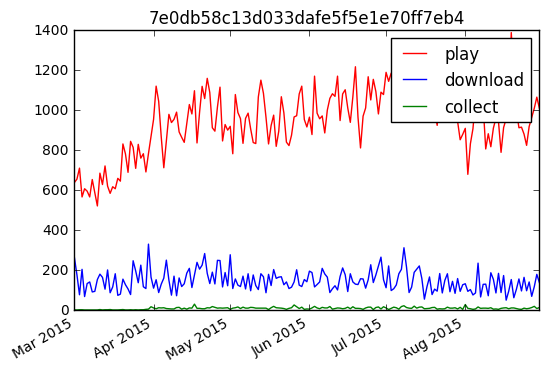

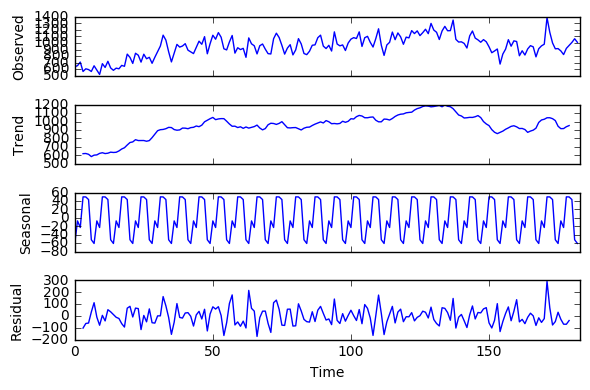

In [24]:
# Get specific artist. Here we show the third artist for example.
artist = artists[2] 

# Get artist's daily information
x = datetimes
y1 = artist_daily_play.loc[:, artist].tolist()
y2 = artist_daily_download.loc[:, artist].tolist()
y3 = artist_daily_collects.loc[:, artist].tolist()

# Plot daily information
fig = plt.figure()  
plt.title(artist)
plt.plot(x, y1, 'r', label='play')
plt.plot(x, y2, 'b', label='download')
plt.plot(x, y3, 'g', label='collect')
plt.legend()
fig.autofmt_xdate()

# Time Series Decomposition
res = sm.tsa.seasonal_decompose(y1, freq = 7)
res.plot()
plt.show()